<a href="https://colab.research.google.com/github/kumar-devesh/cnnvisualizationmedium/blob/main/cnn_explainability_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from urllib import request
from PIL import Image
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
heatmap_dict = {}

(1440, 1920, 4)


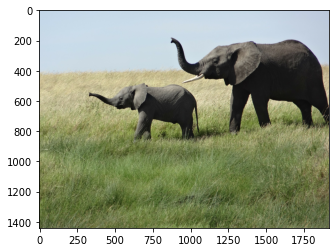

In [ ]:
request.urlretrieve('https://i.imgur.com/Bvro0YD.png', "african_elephant.png")
img = np.array(Image.open("african_elephant.png"))
print(img.shape)
plt.imshow(img)

In [ ]:
def preprocess(img):
  if len(img.shape) > 2 and img.shape[2] == 4:
    #convert the image from RGBA2RGB
    img = np.array(cv2.cvtColor(img, cv2.COLOR_BGRA2BGR))
  img = Image.fromarray(img)
  img = img.resize((224, 224), Image.ANTIALIAS)
  img = np.array(img)/256
  img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
  img = torch.unsqueeze(img, dim = 0)
  return img

def plotImage(image):
  image = np.array(image)
  plt.imshow(np.transpose(image,(1,2,0)))

image size: torch.Size([1, 3, 224, 224])


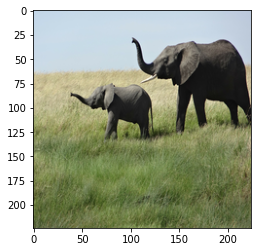

In [ ]:
img = preprocess(img)
print('image size:', img.size())
plotImage(img[0])

In [ ]:
vgg = vgg19(pretrained=True)
features_conv = vgg.features[:36]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        self.id = nn.Identity()
        
        # disect the network to access its last convolutional layer
        self.features_conv = features_conv

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        self.sm = nn.Softmax(dim = -1)

        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def grad_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return self.sm(x)
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
activations = features_conv(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
pred = torch.max(vgg(activations))

In [ ]:
from torch.autograd import grad
def nth_derivative(f, wrt, n):
    for i in range(n):
        grads = grad(f, wrt, create_graph=True, retain_graph=True)[0]
        f = grads.sum()
    return grads

x = torch.tensor(data = [1.0, 2.0, 3.0], requires_grad=True)
loss = (x ** 4).sum()
print(nth_derivative(f=loss, wrt=x, n=3))

tensor([24., 48., 72.], grad_fn=<MulBackward0>)


In [ ]:
dny_dxn = nth_derivative(f = pred, wrt = activations, n=3)

## GradCAM++

In [ ]:
def get_heatmap(Yc, A, eps = 1e-5):

  #alpha value (not accumulated into .grad)
  n = nth_derivative(f=Yc, wrt=A, n=2)
  d = 2*nth_derivative(f=Yc, wrt=A, n=2) + torch.reshape(torch.sum(A, dim = (2, 3)), shape=(A.size()[0], A.size()[1], 1, 1))*nth_derivative(f=Yc, wrt=A, n=3)
  d = np.maximum(d.detach(), 0) + eps
  alpha = torch.div(n, d)

  gradients = nth_derivative(f=Yc, wrt=A, n=1)                                                                                                                                                                    
  gradients = np.maximum(gradients.detach(), 0)*alpha

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = vgg.get_activations(img).detach()

  # weight the channels by corresponding gradients
  for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
  # average the channels of the activations
  activations = activations.detach()
  heatmap = torch.mean(activations, dim=1).squeeze()

  #relu
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= (torch.max(heatmap)+eps)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())
  return heatmap

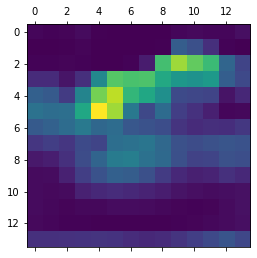

In [ ]:
heatmap = get_heatmap(Yc = pred, A = activations, eps = 1e-5)
heatmap_dict['gradcam++'] = heatmap

## Grad-CAM

In [ ]:
def get_heatmap(Yc, A, eps = 1e-5):
  gradients = nth_derivative(f=Yc, wrt=A, n=1)

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = vgg.get_activations(img).detach()

  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]

  # average the channels of the activations
  activations = activations.detach()
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())
  return heatmap

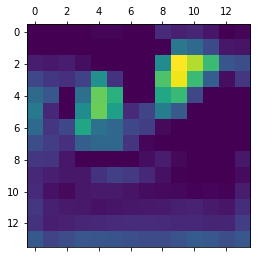

In [ ]:
heatmap = get_heatmap(Yc = pred, A = activations, eps = 1e-5)
heatmap_dict['gradcam'] = heatmap

## Score-CAM

In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

In [ ]:
def upsample(x):
  x = Image.fromarray(np.array(x))
  x = x.resize((224, 224), Image.ANTIALIAS)
  x = torch.tensor(np.array(x), dtype = torch.float32)
  # x -> 224*224 tensors
  return x

In [ ]:
@torch.no_grad()
def get_scores(Yc, A, eps = 1e-5):
  activations = vgg.get_activations(img.to(device)).detach()[0].cpu()
  M = []
  for i in range(activations.size()[0]):
    Mk = upsample(activations[i,:,:].view((14, 14)))*img[0]
    Mk = torch.div(Mk - torch.min(Mk), torch.max(Mk) - Mk + eps)
    M.append(Mk)

  M = torch.stack(M) # batch
  Sc = []
  
  for image in tqdm(M):
    image = torch.unsqueeze(image, 0)
    x = vgg(vgg.get_activations(image.to(device)))
    Sc.append(x[0])
  Sc = torch.stack(Sc).cpu()
  return Sc

In [ ]:
Sc = get_scores(Yc = pred, A = activations, eps = 1e-5)

100%|██████████| 512/512 [00:19<00:00, 25.93it/s]


In [ ]:
@torch.no_grad()
def get_heatmap(Sc):
  print('sc size', Sc.size())
  print(vgg(activations.to(device)).cpu()[0].size())

  values, _ = torch.max(Sc, dim=-1)
  Sc = values - torch.max(vgg(activations.to(device)).cpu()[0])
  alpha = F.softmax(input = Sc, dim=-1).view((512, 1, 1))

  # relu on top of the heatmap
  x = np.maximum(alpha*activations[0].cpu(), 0)
  print(x.shape)
  heatmap = torch.sum(x, dim=0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  plt.matshow(heatmap.squeeze())
  return heatmap

sc size torch.Size([512, 1000])
torch.Size([1000])
torch.Size([512, 14, 14])


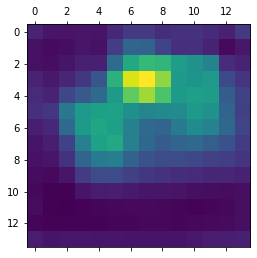

In [ ]:
heatmap = get_heatmap(Sc = Sc)
heatmap_dict['scorecam'] = heatmap

In [ ]:
vgg = vgg.cpu()

## Plot results

In [ ]:
def get_resized_heatmap(hmap):
  hmap = Image.fromarray(np.array(hmap))
  hmap = hmap.resize((224, 224), Image.ANTIALIAS)
  hmap = np.uint8(255*np.array(hmap))
  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[hmap]
  return jet_heatmap

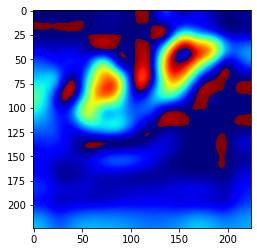

In [ ]:
img_hmap = np.float32(np.array(get_resized_heatmap(heatmap_dict['gradcam'])))
plt.imshow(img_hmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


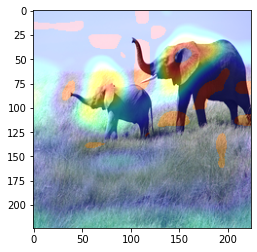

In [ ]:
superimposed_img = np.transpose(np.array(img[0]), (1,2,0)) + img_hmap * 0.4
plt.imshow(superimposed_img)

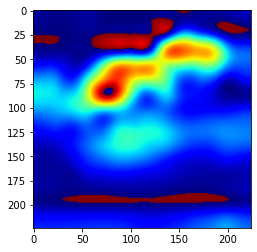

In [ ]:
img_hmap = np.float32(np.array(get_resized_heatmap(heatmap_dict['gradcam++'])))
plt.imshow(img_hmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


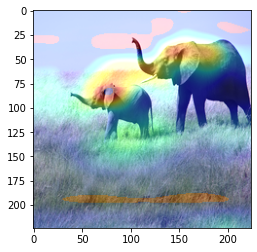

In [ ]:
superimposed_img = np.transpose(np.array(img[0]), (1,2,0)) + img_hmap * 0.4
plt.imshow(superimposed_img)

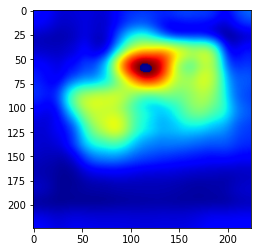

In [ ]:
img_hmap = np.float32(np.array(get_resized_heatmap(heatmap_dict['scorecam'])))
plt.imshow(img_hmap)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


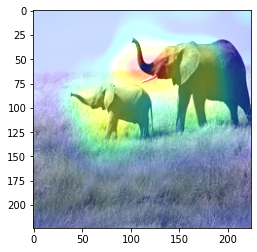

In [ ]:
superimposed_img = np.transpose(np.array(img[0]), (1,2,0)) + img_hmap * 0.4
plt.imshow(superimposed_img)